In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Upload directly in Colab
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('cancer_reg.csv')

Saving cancer_reg.csv to cancer_reg.csv


In [ ]:
# Preview first 5 entries
print(df.head())
df.shape

# DataFrame structure, datatypes, and non-null values
print(df.info())


   index  avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
0      0       1397.0               469             164.9          489.8   
1      1        173.0                70             161.3          411.6   
2      2        102.0                50             174.7          349.7   
3      3        427.0               202             194.8          430.4   
4      4         57.0                26             144.4          350.1   

   medincome  popest2015  povertypercent  studypercap           binnedinc  \
0      61898      260131            11.2   499.748204   (61494.5, 125635]   
1      48127       43269            18.6    23.111234  (48021.6, 51046.4]   
2      49348       21026            14.6    47.560164  (48021.6, 51046.4]   
3      44243       75882            17.1   342.637253    (42724.4, 45201]   
4      49955       10321            12.5     0.000000  (48021.6, 51046.4]   

   ...  pctprivatecoveragealone  pctempprivcoverage  pctpubliccoverage  \
0  ...

Missing Values

In [ ]:
mis_val_count = df.isnull().sum()
mis_val_len  = len(mis_val_count[mis_val_count> 0])
print("Total number of missing entries: ", mis_val_count.sum())
print("Total number of columns that have missing values: ", mis_val_len)
print("These columns are:")
print(mis_val_count[mis_val_count > 0])

Total number of missing entries:  3046
Total number of columns that have missing values:  3
These columns are:
pctsomecol18_24            2285
pctemployed16_over          152
pctprivatecoveragealone     609
dtype: int64


Columns to Drop

In [ ]:
columns_to_drop = ['pctsomecol18_24', 'pctprivatecoveragealone']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f"\nDropped columns with high missing values: {columns_to_drop}")


Dropped columns with high missing values: ['pctsomecol18_24', 'pctprivatecoveragealone']


In [ ]:
# Impute remaining missing numerical values with the median.
# The median is used because it is robust to outliers.
# First, select only the numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns
# Then, fill NaN values in these columns with their respective medians
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median value ({median_val}).")

Filled missing values in 'pctemployed16_over' with median value (54.5).


/tmp/ipython-input-4037524380.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


In [ ]:
# Verify that there are no more missing values
print("\nMissing values count after handling:")
print(df.isnull().sum().sum())


Missing values count after handling:
0


In [ ]:
# --- 3. Removing Duplicates ---
print("\n--- Removing Duplicates ---")
# Check for duplicate rows based on the 'geography' column, which should be unique per county.
duplicate_rows = df[df.duplicated(subset=['geography'], keep=False)]
if not duplicate_rows.empty:
    print(f"Found {len(duplicate_rows)} duplicate rows. Removing them.")
    df.drop_duplicates(subset=['geography'], keep='first', inplace=True)
else:
    print("No duplicate rows found.")


--- Removing Duplicates ---
No duplicate rows found.


In [ ]:
# --- 4. Correcting Inconsistencies and Data Validation ---
print("\n--- Data Validation ---")
# As a validation step, we can check for logical inconsistencies.
# For example, the sum of racial percentages should be close to 100.
racial_pct_cols = ['pctwhite', 'pctblack', 'pctasian', 'pctotherrace']
df['pctracetotal'] = df[racial_pct_cols].sum(axis=1)
# Check for any significant deviations from 100
inconsistent_races = df[(df['pctracetotal'] < 99) | (df['pctracetotal'] > 101)]
if inconsistent_races.empty:
    print("Validation passed: Racial percentages sum up correctly for all counties.")
else:
    print(f"Validation warning: Found {len(inconsistent_races)} counties with inconsistent racial percentages.")
# Drop the temporary total column
df.drop(columns=['pctracetotal'], inplace=True)


--- Data Validation ---
Validation warning: Found 2785 counties with inconsistent racial percentages.


Select Categorical Variables

In [ ]:
# select object columns
object_col = [col for col in df.columns if df[col].dtype == 'object']
print("Object columns: ", object_col)

Object columns:  ['binnedinc', 'geography']


In [ ]:
print("Unique values in 'geography' column: \n", df['geography'].unique())
print("Number of the unique values is: ", df['geography'].nunique())

print('-'*280)

print("Unique values in 'binnedinc' column: \n", df['binnedinc'].unique())
print("Number of the unique values is: ", df['binnedinc'].nunique())

Unique values in 'geography' column: 
 ['Kitsap County, Washington' 'Kittitas County, Washington'
 'Klickitat County, Washington' ... 'Ford County, Kansas'
 'Franklin County, Kansas' 'Geary County, Kansas']
Number of the unique values is:  3047
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Unique values in 'binnedinc' column: 
 ['(61494.5, 125635]' '(48021.6, 51046.4]' '(42724.4, 45201]'
 '(51046.4, 54545.6]' '(37413.8, 40362.7]' '(40362.7, 42724.4]'
 '(54545.6, 61494.5]' '(34218.1, 37413.8]' '[22640, 34218.1]'
 '(45201, 48021.6]']
Number of the unique values is:  10


In [ ]:
# --- 6. Data Transformation for Skewed Variables ---
# This step is often done in preparation for statistical modeling.
print("\n--- Data Transformation ---")
# Log-transform skewed numerical variables to normalize their distribution.
# This helps in meeting the assumptions of linear regression models.
# We will add new columns for the transformed data to preserve the original values.
skewed_cols = ['medincome', 'popest2015']
for col in skewed_cols:
    df[f'{col}_log10'] = np.log10(df[col])
    print(f"Created log-transformed column for '{col}'.")


--- Data Transformation ---
Created log-transformed column for 'medincome'.
Created log-transformed column for 'popest2015'.


In [ ]:
# --- Final Cleaned Data Overview ---
print("\n--- Cleaned Data Overview ---")
print("\nDataFrame Info after Cleaning:")
df.info()


--- Cleaned Data Overview ---

DataFrame Info after Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   3047 non-null   int64  
 1   avganncount             3047 non-null   float64
 2   avgdeathsperyear        3047 non-null   int64  
 3   target_deathrate        3047 non-null   float64
 4   incidencerate           3047 non-null   float64
 5   medincome               3047 non-null   int64  
 6   popest2015              3047 non-null   int64  
 7   povertypercent          3047 non-null   float64
 8   studypercap             3047 non-null   float64
 9   binnedinc               3047 non-null   object 
 10  medianage               3047 non-null   float64
 11  medianagemale           3047 non-null   float64
 12  medianagefemale         3047 non-null   float64
 13  geography               3047 n

In [ ]:
df.describe()

,index,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,...,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,medincome_log10,popest2015_log10
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3.047000e+03,3047.000000,3047.000000,3047.000000,...,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,1523.000000,606.338544,185.965868,178.664063,448.268586,47063.281917,1.026374e+05,16.878175,155.399415,45.272333,...,36.252642,19.240072,83.645286,9.107978,1.253965,1.983523,51.243872,5.640306,4.659956,4.488001
std,879.737461,1416.356223,504.134286,27.751511,54.560733,12040.090836,3.290592e+05,6.409087,529.628366,45.304480,...,7.841741,6.113041,16.380025,14.534538,2.610276,3.517710,6.572814,1.985816,0.103309,0.612149
min,0.000000,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,...,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000,4.354876,2.917506
25%,761.500000,76.000000,28.000000,161.200000,420.300000,38882.500000,1.168400e+04,12.150000,0.000000,37.700000,...,30.900000,14.850000,77.296180,0.620675,0.254199,0.295172,47.763063,4.521419,4.589754,4.067591
50%,1523.000000,171.000000,61.000000,178.100000,453.549422,45207.000000,2.664300e+04,15.900000,0.000000,41.000000,...,36.300000,18.800000,90.059774,2.247576,0.549812,0.826185,51.669941,5.381478,4.655206,4.425583
75%,2284.500000,518.000000,149.000000,195.200000,480.850000,52492.000000,6.867100e+04,20.400000,83.650776,44.000000,...,41.550000,23.100000,95.451693,10.509732,1.221037,2.177960,55.395132,6.493677,4.720093,4.836773
max,3046.000000,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,...,65.100000,46.600000,100.000000,85.947799,42.619425,41.930251,78.075397,21.326165,5.099111,7.007333


Data Quality

In [ ]:
df.isnull().sum()

,0
index,0
avganncount,0
avgdeathsperyear,0
target_deathrate,0
incidencerate,0
medincome,0
popest2015,0
povertypercent,0
studypercap,0
binnedinc,0


In [ ]:
df.duplicated().sum()

np.int64(0)

Statistical Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
# --- 2. Selecting Relevant Data for Analysis ---

# For this analysis, we are interested in the correlation between socio-economic factors and cancer rates.
# We will select the relevant columns for this purpose.
socio_economic_cols = ['medincome', 'povertypercent', 'pctunemployed16_over']
chronic_disease_cols = ['target_deathrate', 'incidencerate']
categorical_col = 'binnedinc'

In [ ]:
# Create a new DataFrame with only the columns of interest
analysis_df = df[socio_economic_cols + chronic_disease_cols + [categorical_col]].copy()

In [ ]:
# --- 3. Descriptive Statistics ---

print("## Descriptive Statistics of Key Variables")
print("This table provides a summary of the central tendency, dispersion, and shape of the distribution of the dataset.")
print(analysis_df[socio_economic_cols + chronic_disease_cols].describe())
print("\n" + "="*80 + "\n")

## Descriptive Statistics of Key Variables
This table provides a summary of the central tendency, dispersion, and shape of the distribution of the dataset.
           medincome  povertypercent  pctunemployed16_over  target_deathrate  \
count    3047.000000     3047.000000           3047.000000       3047.000000   
mean    47063.281917       16.878175              7.852412        178.664063   
std     12040.090836        6.409087              3.452371         27.751511   
min     22640.000000        3.200000              0.400000         59.700000   
25%     38882.500000       12.150000              5.500000        161.200000   
50%     45207.000000       15.900000              7.600000        178.100000   
75%     52492.000000       20.400000              9.700000        195.200000   
max    125635.000000       47.400000             29.400000        362.800000   

       incidencerate  
count    3047.000000  
mean      448.268586  
std        54.560733  
min       201.300000  
25%     

In [ ]:
# --- 4. Correlation Analysis and Heatmap ---

print("## Correlation Matrix and Heatmap")
print("The following heatmap visualizes the correlation between socio-economic factors and cancer rates.")
print("A value close to 1 indicates a strong positive correlation, while a value close to -1 indicates a strong negative correlation. A value near 0 suggests no correlation.\n")

## Correlation Matrix and Heatmap
The following heatmap visualizes the correlation between socio-economic factors and cancer rates.
A value close to 1 indicates a strong positive correlation, while a value close to -1 indicates a strong negative correlation. A value near 0 suggests no correlation.



In [ ]:
# Calculate the correlation matrix
correlation_matrix = analysis_df[socio_economic_cols + chronic_disease_cols].corr()
print(correlation_matrix)

                      medincome  povertypercent  pctunemployed16_over  \
medincome              1.000000       -0.788965             -0.453108   
povertypercent        -0.788965        1.000000              0.655148   
pctunemployed16_over  -0.453108        0.655148              1.000000   
target_deathrate      -0.428615        0.429389              0.378412   
incidencerate         -0.001036        0.009046              0.099979   

                      target_deathrate  incidencerate  
medincome                    -0.428615      -0.001036  
povertypercent                0.429389       0.009046  
pctunemployed16_over          0.378412       0.099979  
target_deathrate              1.000000       0.449432  
incidencerate                 0.449432       1.000000  


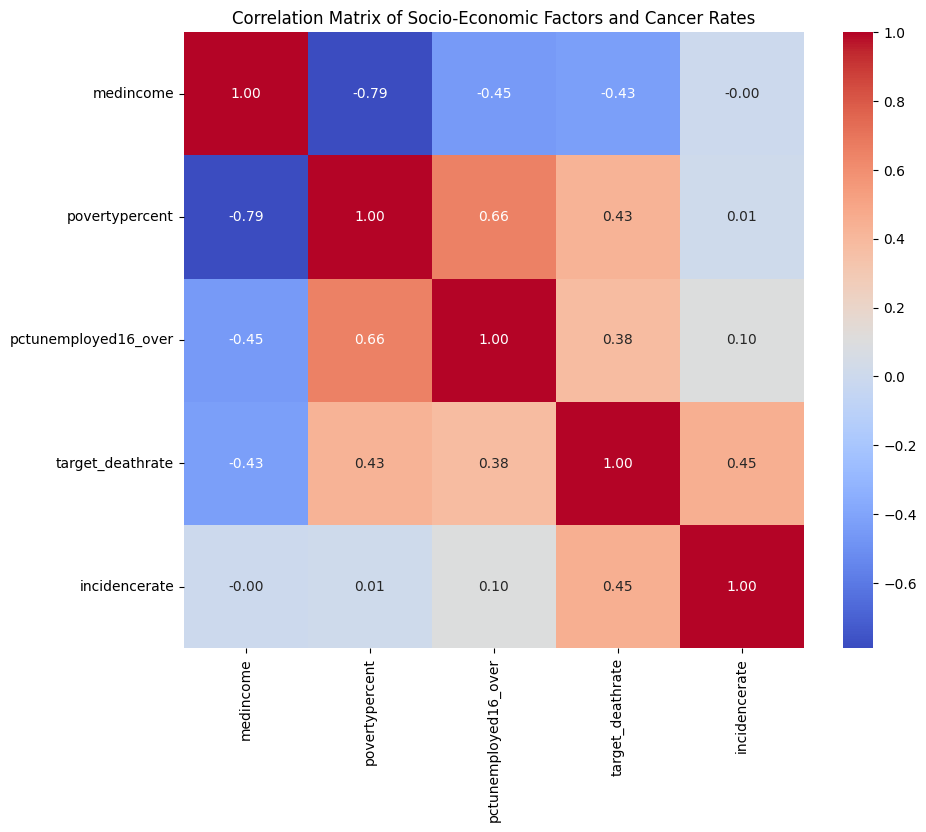

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Socio-Economic Factors and Cancer Rates')
plt.show()
print("\n" + "="*80 + "\n")

In [ ]:
# --- 5. Visualizing Distributions with Violin and Box Plots ---

print("## Distribution of Cancer Death Rate by Income Bracket")
print("The violin and box plots below show the distribution of cancer death rates across different median income brackets.\n")

# Sort the binned income column for better visualization
income_order = sorted(analysis_df['binnedinc'].unique())

## Distribution of Cancer Death Rate by Income Bracket
The violin and box plots below show the distribution of cancer death rates across different median income brackets.



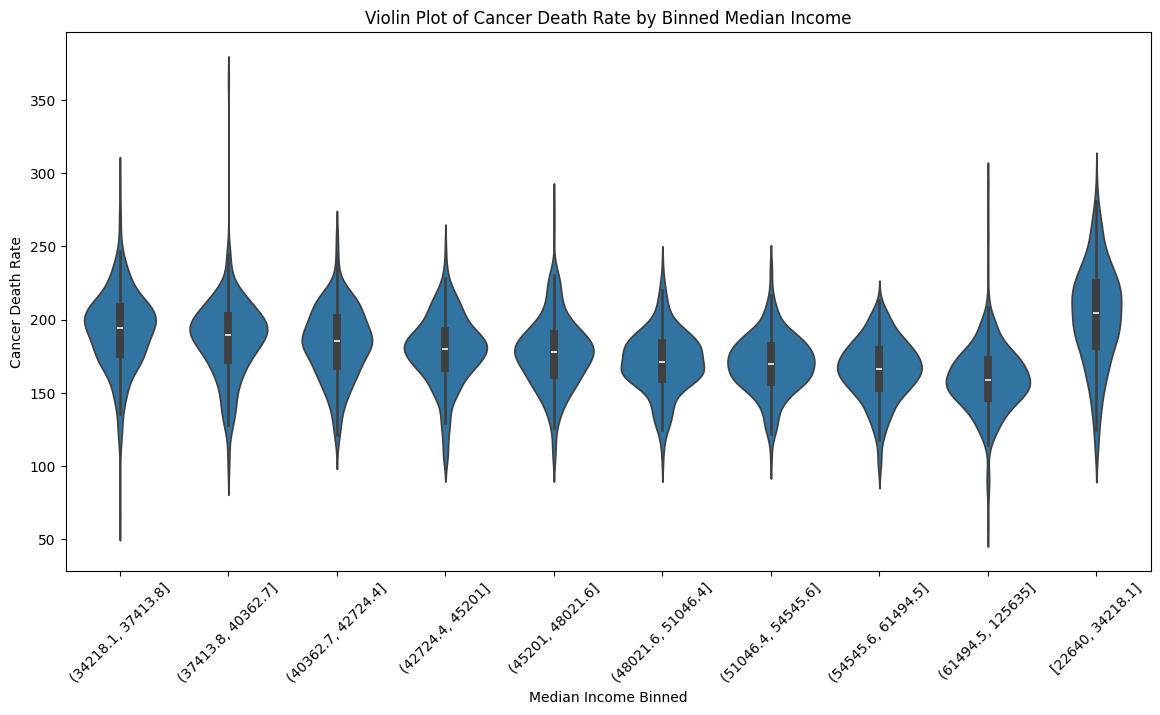

In [ ]:
# Violin Plot
plt.figure(figsize=(14, 7))
sns.violinplot(x='binnedinc', y='target_deathrate', data=analysis_df, order=income_order)
plt.xlabel("Median Income Binned")
plt.ylabel("Cancer Death Rate")
plt.title("Violin Plot of Cancer Death Rate by Binned Median Income")
plt.xticks(rotation=45)
plt.show()

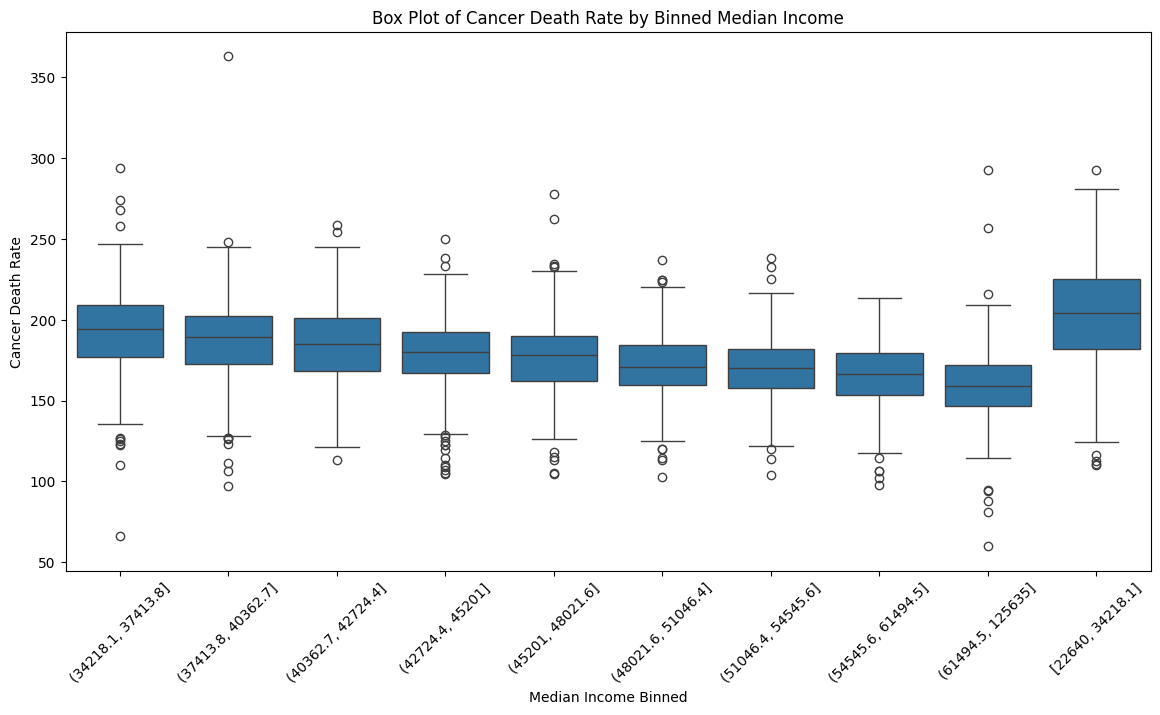

In [ ]:
# Box Plot
plt.figure(figsize=(14, 7))
sns.boxplot(x='binnedinc', y='target_deathrate', data=analysis_df, order=income_order)
plt.xlabel("Median Income Binned")
plt.ylabel("Cancer Death Rate")
plt.title("Box Plot of Cancer Death Rate by Binned Median Income")
plt.xticks(rotation=45)
plt.show()
print("\n" + "="*80 + "\n")

In [ ]:
# --- 6. Chi-Square Test for Independence ---

print("## Chi-Square Test: Income vs. High/Low Cancer Death Rate")
print("This test determines if there is a significant association between median income brackets and whether a county has a high or low cancer death rate.\n")

## Chi-Square Test: Income vs. High/Low Cancer Death Rate
This test determines if there is a significant association between median income brackets and whether a county has a high or low cancer death rate.



In [ ]:
# Create a binary categorical variable for high/low death rate
median_death_rate = analysis_df['target_deathrate'].median()
analysis_df['death_rate_category'] = pd.cut(
    analysis_df['target_deathrate'],
    bins=[-np.inf, median_death_rate, np.inf],
    labels=['Low', 'High']
)

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(analysis_df['binnedinc'], analysis_df['death_rate_category'])

print("Contingency Table:")
print(contingency_table)
print("\n")

Contingency Table:
death_rate_category  Low  High
binnedinc                     
(34218.1, 37413.8]    83   221
(37413.8, 40362.7]    91   213
(40362.7, 42724.4]   112   192
(42724.4, 45201]     136   169
(45201, 48021.6]     155   151
(48021.6, 51046.4]   193   112
(51046.4, 54545.6]   206    99
(54545.6, 61494.5]   226    80
(61494.5, 125635]    255    47
[22640, 34218.1]      67   239




In [ ]:
# Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi-Square Statistic: 504.93
P-value: 5.063240865308076e-103
Degrees of Freedom: 9


In [ ]:
# Interpretation of the p-value
alpha = 0.05
if p_value < alpha:
    print("\nInterpretation: The p-value is less than 0.05, so we reject the null hypothesis.")
    print("There is a statistically significant association between median income and cancer death rates.")
else:
    print("\nInterpretation: The p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between median income and cancer death rates.")


Interpretation: The p-value is less than 0.05, so we reject the null hypothesis.
There is a statistically significant association between median income and cancer death rates.


Algorithm and Prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
# --- 2. Feature Selection ---

# Select socio-economic factors as features (X) and the cancer death rate as the target (y)
features = [
    'medincome',
    'povertypercent',
    'pctunemployed16_over',
    'pcths25_over',
    'pctbachdeg25_over',
    'pctemployed16_over'
]
target = 'target_deathrate'

X = df[features]
y = df[target]

In [ ]:
# --- 3. Train-Test Split ---

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --- 4. Model Training ---

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# --- 5. Prediction ---

# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# --- 6. Model Evaluation ---

print("## Machine Learning Model Performance Metrics")
print("These metrics help us understand how well our model is performing.\n")

# Calculate and print performance metrics
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

print("\n### Interpretation of Metrics:")
print(f"- **MAE**: On average, the model's predictions are off by approximately {mae:.2f} units from the actual death rate.")
print(f"- **R-squared**: Approximately {r2*100:.2f}% of the variance in the cancer death rate can be explained by the socio-economic factors in our model.")
print("\n" + "="*80 + "\n")

## Machine Learning Model Performance Metrics
These metrics help us understand how well our model is performing.

Mean Absolute Error (MAE): 17.26
Mean Squared Error (MSE): 545.92
Root Mean Squared Error (RMSE): 23.37
R-squared: 0.33

### Interpretation of Metrics:
- **MAE**: On average, the model's predictions are off by approximately 17.26 units from the actual death rate.
- **R-squared**: Approximately 33.28% of the variance in the cancer death rate can be explained by the socio-economic factors in our model.




## Visualization of Actual vs. Predicted Values
This scatter plot shows how the model's predictions compare to the actual cancer death rates.



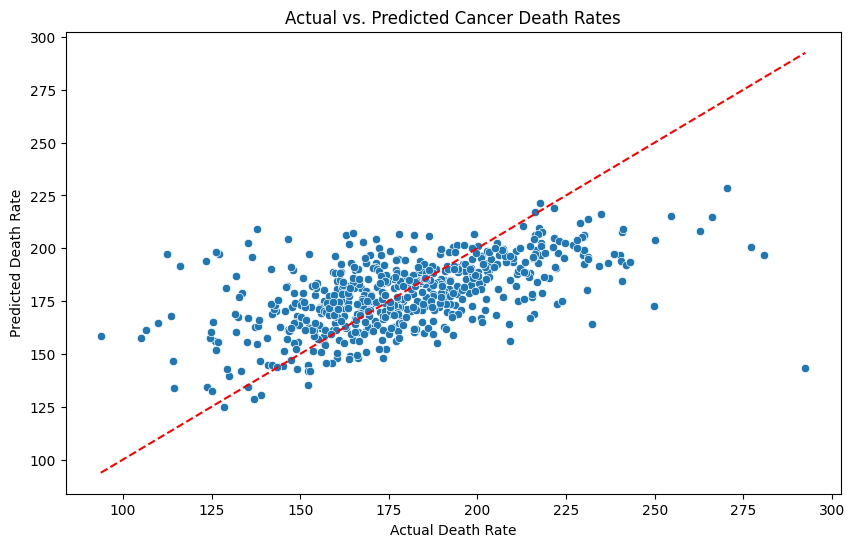

In [ ]:
# --- 7. Visualization of Predictions ---

print("## Visualization of Actual vs. Predicted Values")
print("This scatter plot shows how the model's predictions compare to the actual cancer death rates.\n")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Death Rate")
plt.ylabel("Predicted Death Rate")
plt.title("Actual vs. Predicted Cancer Death Rates")
# Add a line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

Data Visualizations

In [ ]:
# Drop any remaining rows with missing values
df.dropna(inplace=True)

In [ ]:
# --- 2. Data Visualization ---

print("## Data Visualizations for Exploratory Data Analysis")
print("The following plots will help us explore the relationships within the data.\n")

## Data Visualizations for Exploratory Data Analysis
The following plots will help us explore the relationships within the data.



### Histograms: Understanding Distributions
These plots show the distribution of our key variables: cancer death rate, median income, and poverty percentage.



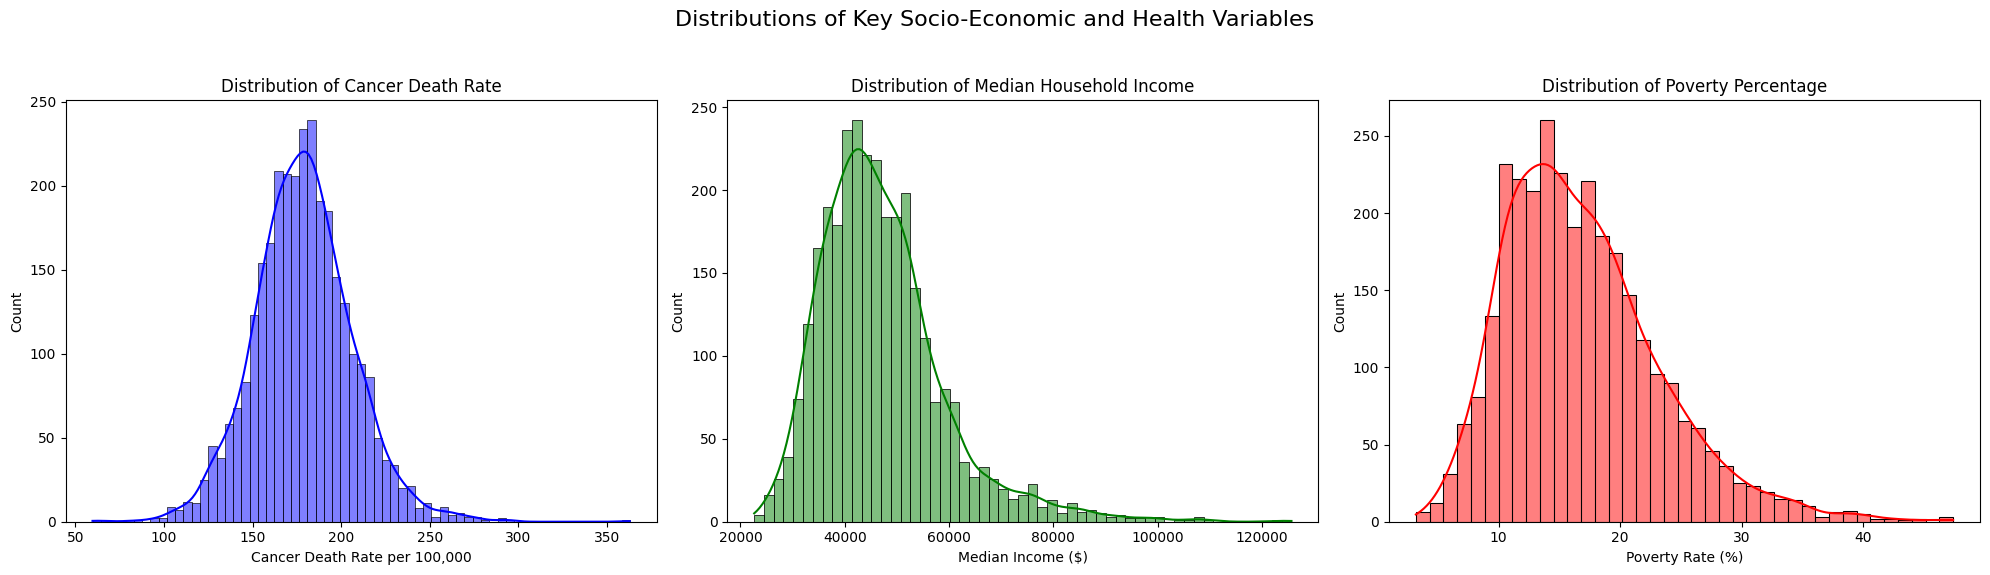

In [ ]:
# === Plot 1: Histograms of Key Variables ===
print("### Histograms: Understanding Distributions")
print("These plots show the distribution of our key variables: cancer death rate, median income, and poverty percentage.\n")

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Key Socio-Economic and Health Variables', fontsize=16)

# Histogram for Target Death Rate
sns.histplot(df['target_deathrate'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Cancer Death Rate')
axes[0].set_xlabel('Cancer Death Rate per 100,000')

# Histogram for Median Income
sns.histplot(df['medincome'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Median Household Income')
axes[1].set_xlabel('Median Income ($)')

# Histogram for Poverty Percentage
sns.histplot(df['povertypercent'], kde=True, ax=axes[2], color='red')
axes[2].set_title('Distribution of Poverty Percentage')
axes[2].set_xlabel('Poverty Rate (%)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show() # This will now display the figure with all three histograms
print("\n" + "="*80 + "\n")

### Scatter Plot: Median Income vs. Cancer Death Rate
This plot visualizes the relationship between median income and cancer death rates. The line shows the general trend.



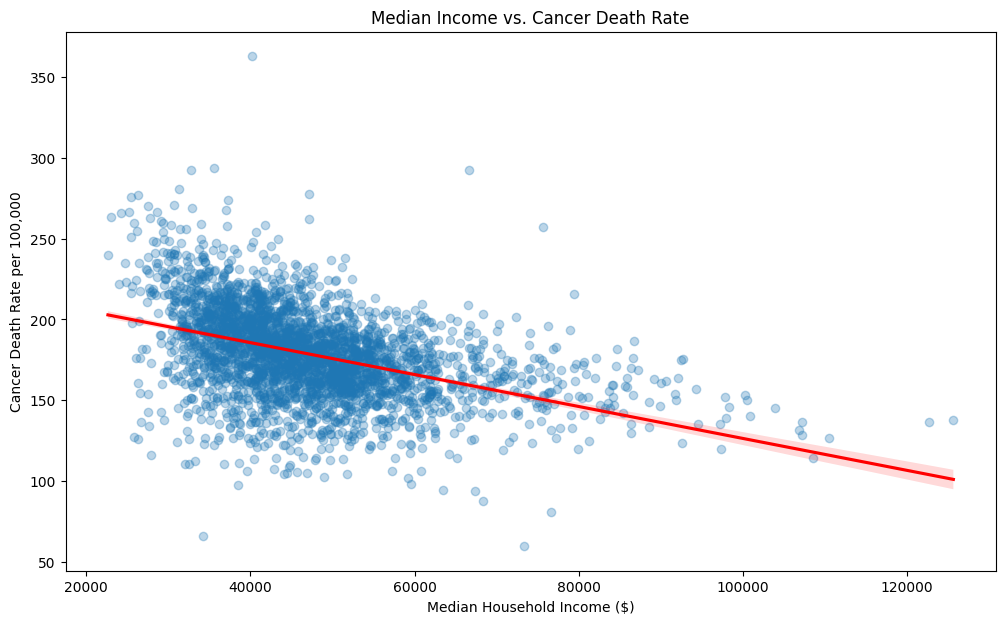

In [ ]:
# === Plot 2: Scatter Plot with Regression Line ===
print("### Scatter Plot: Median Income vs. Cancer Death Rate")
print("This plot visualizes the relationship between median income and cancer death rates. The line shows the general trend.\n")

plt.figure(figsize=(12, 7))
sns.regplot(x='medincome', y='target_deathrate', data=df,
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Median Income vs. Cancer Death Rate')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Cancer Death Rate per 100,000')
plt.show()
print("\n" + "="*80 + "\n")

### Joint Plot: Poverty Rate vs. Cancer Death Rate
This plot combines a scatter plot with histograms to show both the relationship and the individual distributions.



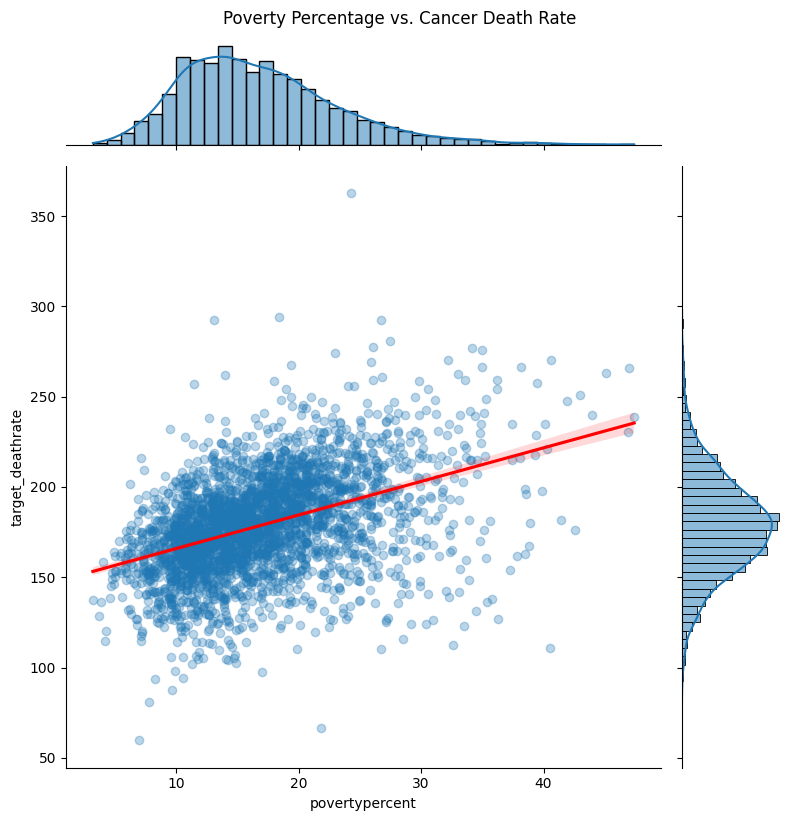

In [ ]:
# === Plot 3: Joint Plot for Deeper Insight ===
print("### Joint Plot: Poverty Rate vs. Cancer Death Rate")
print("This plot combines a scatter plot with histograms to show both the relationship and the individual distributions.\n")

sns.jointplot(x='povertypercent', y='target_deathrate', data=df, kind='reg',
              height=8, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.suptitle('Poverty Percentage vs. Cancer Death Rate', y=1.02)
plt.show()
print("\n" + "="*80 + "\n")

### Bar Chart: Average Death Rate by Income Bracket (Corrected)


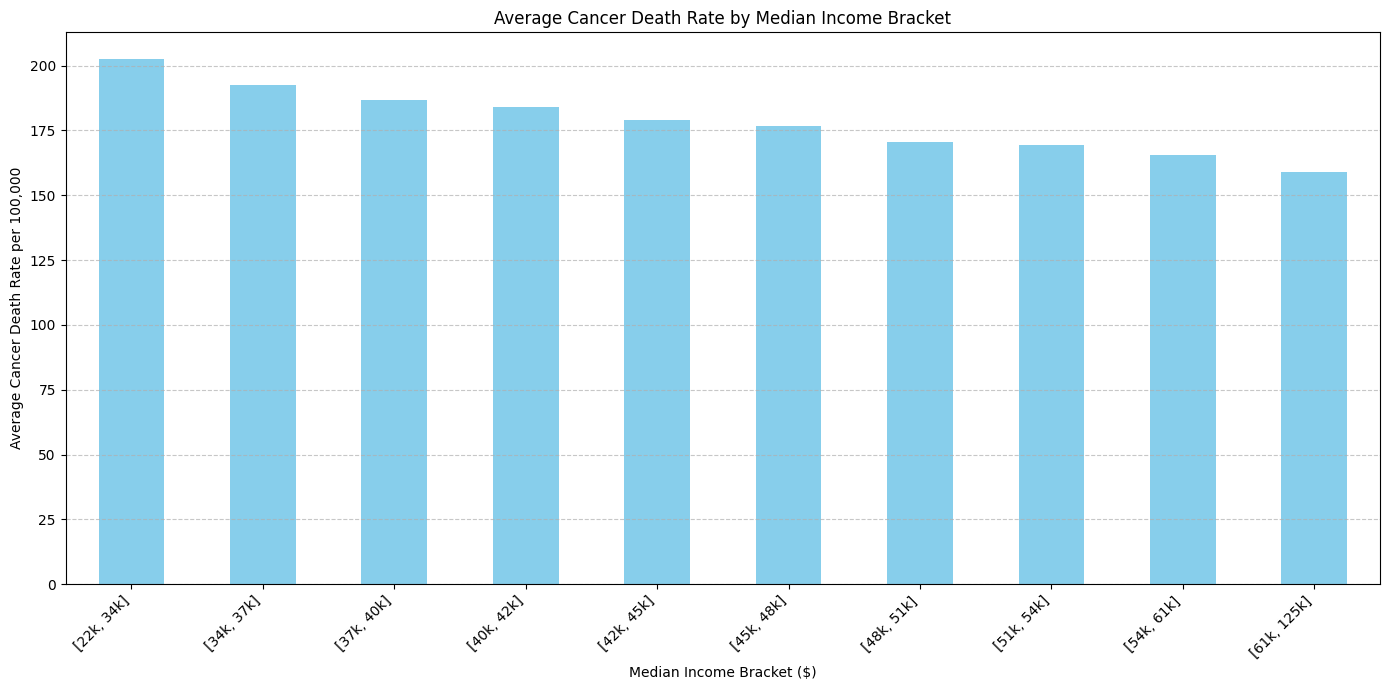

In [ ]:
# === Plot 4: Bar Chart for Binned Income ===
print("### Bar Chart: Average Death Rate by Income Bracket (Corrected)")

if 'binnedinc' in df.columns:
    # --- FIX STARTS HERE ---

    # 1. Calculate the average death rate for each income bracket
    avg_deathrate_by_income = df.groupby('binnedinc')['target_deathrate'].mean()

    # 2. Correct the sorting by creating a numeric key from the bin's starting value
    # Adjusted regex to handle both '(' and '[' at the start of the bin string
    sort_key = avg_deathrate_by_income.index.str.extract(r'[\[(](\d+\.?\d*)').astype(float).values[:, 0]
    sorted_avg_deathrate = avg_deathrate_by_income.iloc[np.argsort(sort_key)]

    # 3. Create new labels
    def format_label(label_str):
        # Handle both '(' and '[' at the start of the string
        parts = label_str.replace('(', '').replace('[', '').replace(']', '').split(',')
        low = int(float(parts[0])) // 1000
        high = int(float(parts[1])) // 1000
        return f'[{low}k, {high}k]'

    new_labels = [format_label(label) for label in sorted_avg_deathrate.index]

    # 4. Plot the data with the corrected sorting and new labels
    plt.figure(figsize=(14, 7))
    ax = sorted_avg_deathrate.plot(kind='bar', color='skyblue')
    plt.title('Average Cancer Death Rate by Median Income Bracket')
    plt.xlabel('Median Income Bracket ($)')
    plt.ylabel('Average Cancer Death Rate per 100,000')

    # Set the custom formatted labels on the x-axis
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to prevent labels from being cut off
    plt.show()
else:
    print("Column 'binnedinc' not found, skipping Plot 4.")

Top 5 U.S. Counties with Most Cancer Death Rates

/tmp/ipython-input-2657388463.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='target_deathrate', y='full_geography', data=top_5_hotspots, palette='plasma')


Visualization 'top_5_hotspot_counties.png' created successfully.


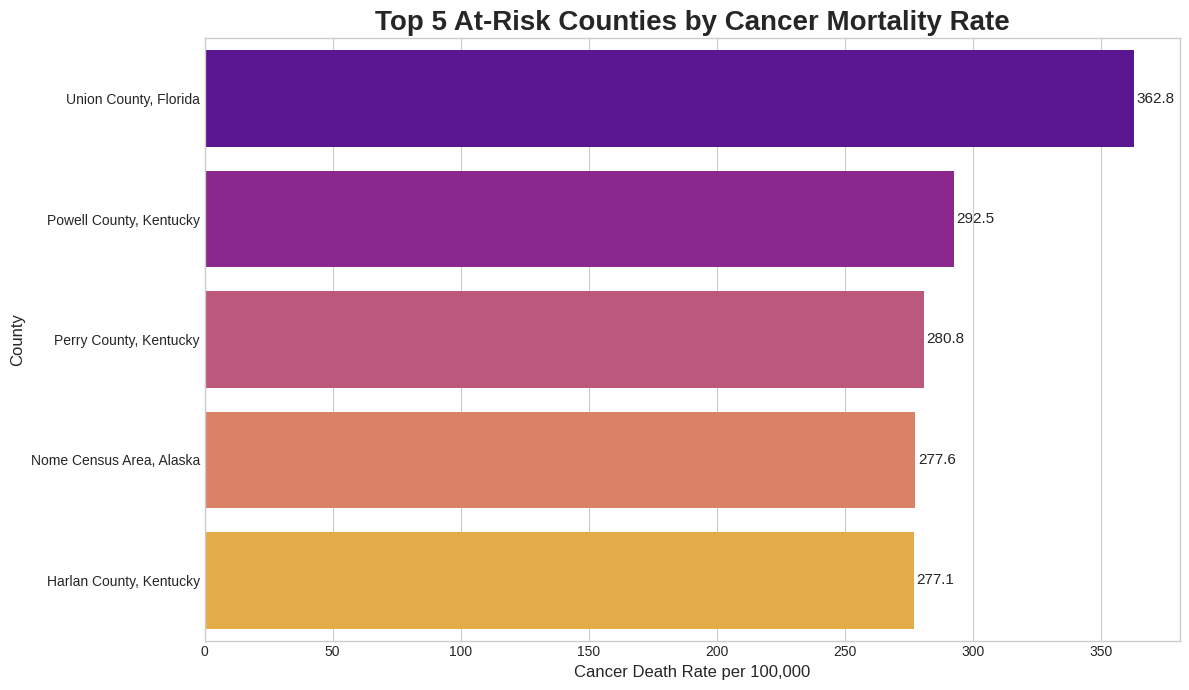

Text file 'all_at_risk_counties.txt' with all county names has been created.


In [ ]:
def analyze_and_visualize_top_hotspots():
    """
    Identifies the top 5 at-risk counties by cancer mortality rate,
    creates a bar chart to visualize them, and saves a text file
    listing all at-risk counties by state.
    """
    try:
        df = pd.read_csv('cancer_reg.csv')
    except FileNotFoundError:
        print("Error: 'cancer_reg.csv' not found. Make sure the file is in the same directory.")
        return

    # --- 1. Data Cleaning & Preparation ---
    df.dropna(subset=['povertypercent', 'target_deathrate', 'geography'], inplace=True)

    try:
        geo_split = df['geography'].str.split(', ', expand=True)
        df['County'] = geo_split[0]
        df['State'] = geo_split[1]
    except Exception as e:
        print(f"Could not parse the 'geography' column. Error: {e}")
        return

    # --- 2. Identify All Hotspot Counties ---
    poverty_top_quartile = df['povertypercent'].quantile(0.75)
    death_rate_top_quartile = df['target_deathrate'].quantile(0.75)

    df['is_hotspot'] = (df['povertypercent'] >= poverty_top_quartile) & \
                      (df['target_deathrate'] >= death_rate_top_quartile)

    hotspot_df = df[df['is_hotspot']].copy()

    # --- 3. Get Top 5 Counties by Mortality Rate ---
    top_5_hotspots = hotspot_df.sort_values('target_deathrate', ascending=False).head(5)
    top_5_hotspots['full_geography'] = top_5_hotspots['County'] + ', ' + top_5_hotspots['State']

    # --- 4. Create Bar Chart Visualization ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(x='target_deathrate', y='full_geography', data=top_5_hotspots, palette='plasma')

    plt.title('Top 5 At-Risk Counties by Cancer Mortality Rate', fontsize=20, weight='bold')
    plt.xlabel('Cancer Death Rate per 100,000', fontsize=12)
    plt.ylabel('County', fontsize=12)

    # Add data labels to the bars
    for bar in ax.patches:
        ax.text(bar.get_width() + 1,            # Position x
                bar.get_y() + bar.get_height() / 2, # Position y
                f'{bar.get_width():.1f}',       # Label text
                va='center', ha='left',          # Alignment
                fontsize=11)

    plt.tight_layout()
    plt.savefig('top_5_hotspot_counties.png')
    print("Visualization 'top_5_hotspot_counties.png' created successfully.")
    plt.show()

    # --- 5. Generate Text File with All Hotspot County Names ---
    try:
        with open('all_at_risk_counties.txt', 'w') as f:
            f.write("List of All At-Risk Counties (Top 25% in Poverty & Cancer Mortality)\n")
            f.write("="*70 + "\n\n")
            grouped = hotspot_df.groupby('State')['County'].apply(list)
            for state, counties in grouped.items():
                f.write(f"--- {state} ---\n")
                for county in sorted(counties):
                    f.write(f"- {county}\n")
                f.write("\n")
        print("Text file 'all_at_risk_counties.txt' with all county names has been created.")
    except Exception as e:
        print(f"Could not write the text file. Error: {e}")

if __name__ == '__main__':
    analyze_and_visualize_top_hotspots()

Top 5 U.S. States ranked with most number of US counties at risk of Cancer Mortality



/tmp/ipython-input-840301962.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=hotspot_df['State'], order=top_5_states_order, palette='viridis')


Visualization 'top_5_states_hotspot_counties.png' created successfully.


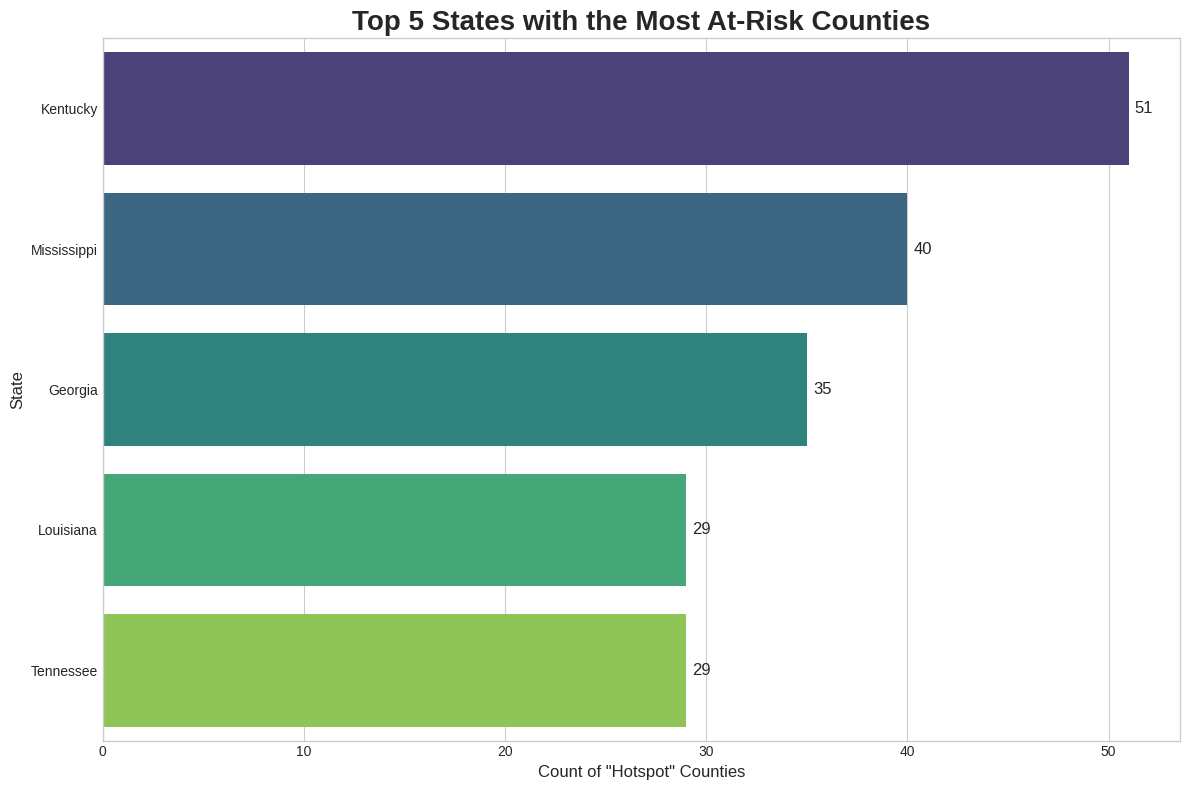

Text file 'at_risk_county_list.txt' with all county names has been created.


In [ ]:
def analyze_and_visualize_hotspots():
    """
    Identifies at-risk counties, creates a bar chart showing the top 5 states
    with the most at-risk counties, and saves a text file listing all of them.
    """
    try:
        df = pd.read_csv('cancer_reg.csv')
    except FileNotFoundError:
        print("Error: 'cancer_reg.csv' not found. Make sure the file is in the same directory.")
        return

    # --- 1. Data Cleaning & Preparation ---
    df.dropna(subset=['povertypercent', 'target_deathrate', 'geography'], inplace=True)

    # Parse the 'geography' column to get County and State
    try:
        geo_split = df['geography'].str.split(', ', expand=True)
        df['County'] = geo_split[0]
        df['State'] = geo_split[1]
    except Exception as e:
        print(f"Could not parse the 'geography' column. Error: {e}")
        return

    # --- 2. Identify Hotspot Counties ---
    poverty_top_quartile = df['povertypercent'].quantile(0.75)
    death_rate_top_quartile = df['target_deathrate'].quantile(0.75)

    df['is_hotspot'] = (df['povertypercent'] >= poverty_top_quartile) & \
                      (df['target_deathrate'] >= death_rate_top_quartile)

    hotspot_df = df[df['is_hotspot']].copy()

    # --- 3. Create Bar Chart Visualization for Top 5 States ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    # Get the top 5 states by count of hotspot counties
    top_5_states_order = hotspot_df['State'].value_counts().nlargest(5).index

    ax = sns.countplot(y=hotspot_df['State'], order=top_5_states_order, palette='viridis')

    plt.title('Top 5 States with the Most At-Risk Counties', fontsize=20, weight='bold')
    plt.xlabel('Count of "Hotspot" Counties', fontsize=12)
    plt.ylabel('State', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add data labels to the bars
    for bar in ax.patches:
        ax.text(bar.get_width() + 0.3, # Position x
                bar.get_y() + bar.get_height() / 2, # Position y
                f'{int(bar.get_width())}', # Label text
                va='center', ha='left', # Alignment
                fontsize=12)

    plt.tight_layout()

    # Save the visualization
    plt.savefig('top_5_states_hotspot_counties.png')
    print("Visualization 'top_5_states_hotspot_counties.png' created successfully.")
    plt.show()

    # --- 4. Generate Text File with Full County List ---
    try:
        with open('at_risk_county_list.txt', 'w') as f:
            f.write("List of All At-Risk Counties (Top 25% in Poverty & Cancer Mortality)\n")
            f.write("="*70 + "\n\n")

            # Group by state and list counties
            grouped = hotspot_df.groupby('State')['County'].apply(list)

            for state, counties in grouped.items():
                f.write(f"--- {state} ---\n")
                for county in sorted(counties):
                    f.write(f"- {county}\n")
                f.write("\n")

        print("Text file 'at_risk_county_list.txt' with all county names has been created.")
    except Exception as e:
        print(f"Could not write the text file. Error: {e}")


if __name__ == '__main__':
    analyze_and_visualize_hotspots()